# Breach Cost Prediction Analysis - PDF Report Generator

This notebook generates a comprehensive PDF report summarizing the machine learning pipeline for cybersecurity breach cost prediction based on network traffic analysis.

In [1]:
# Import Required Libraries and Load Data
import json
import warnings
import joblib
import os
from datetime import datetime
from pathlib import Path

warnings.filterwarnings('ignore')

# Data analysis and machine learning
import numpy as np
import pandas as pd
from scipy import stats
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Statistical analysis
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools import add_constant
    from statsmodels.graphics.gofplots import ProbPlot
except ImportError:
    print("Installing statsmodels...")
    import subprocess
    subprocess.run(['pip', 'install', 'statsmodels'], check=True)
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools import add_constant
    from statsmodels.graphics.gofplots import ProbPlot

# PDF generation libraries
try:
    from reportlab.lib.pagesizes import letter, A4
    from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, PageBreak, Table, TableStyle
    from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
    from reportlab.lib.units import inch
    from reportlab.lib import colors
    from reportlab.graphics.shapes import Drawing
    from reportlab.graphics.charts.lineplots import LinePlot
    from reportlab.graphics.charts.legends import Legend
    from reportlab.lib.enums import TA_CENTER, TA_JUSTIFY, TA_LEFT
except ImportError:
    print("Installing reportlab...")
    import subprocess
    subprocess.run(['pip', 'install', 'reportlab'], check=True)
    from reportlab.lib.pagesizes import letter, A4
    from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, PageBreak, Table, TableStyle
    from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
    from reportlab.lib.units import inch
    from reportlab.lib import colors
    from reportlab.graphics.shapes import Drawing
    from reportlab.graphics.charts.lineplots import LinePlot
    from reportlab.graphics.charts.legends import Legend
    from reportlab.lib.enums import TA_CENTER, TA_JUSTIFY, TA_LEFT

# Set random seed for reproducibility
np.random.seed(42)

# Define constants
PREDICTOR_COLUMNS = [
    'Total Fwd Packets',
    'Total Backward Packets',
    'Fwd Packet Length Mean',
    'Flow Duration',
    'Average Packet Size'
]
SYNTHETIC_TARGET = 'Estimated_Breach_Cost'

print("All libraries imported successfully!")
print(f"Analysis timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

All libraries imported successfully!
Analysis timestamp: 2025-09-27 22:29:50


In [2]:
# Load or generate synthetic dataset
def load_or_generate_data():
    """Load the network traffic dataset or generate synthetic data for demonstration"""
    # Try to load actual dataset
    csv_path = 'D:/7th SEMESTER/ML/ASSINGMENT 2/Friday-WorkingHours-Morning.pcap_ISCX.csv'
    
    if Path(csv_path).exists():
        print(f"Loading dataset from: {csv_path}")
        df = pd.read_csv(csv_path)
        data_source = "Real Dataset"
    else:
        print("Dataset not found. Generating synthetic data for demonstration.")
        # Generate synthetic network traffic data
        n_samples = 2000
        df = pd.DataFrame({
            'Total Fwd Packets': np.random.randint(1, 8000, n_samples),
            'Total Backward Packets': np.random.randint(0, 6000, n_samples),
            'Fwd Packet Length Mean': np.random.uniform(0, 300, n_samples),
            'Flow Duration': np.random.randint(0, 2_000_000, n_samples),
            'Average Packet Size': np.random.uniform(0, 1500, n_samples)
        })
        data_source = "Synthetic Dataset"
    
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df, data_source

# Load the data
df_raw, data_source = load_or_generate_data()

# Display basic information
print("\nDataset Overview:")
print(f"Shape: {df_raw.shape}")
print(f"Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nFirst 5 rows:")
display(df_raw.head())
print("\nData types:")
print(df_raw.dtypes)
print("\nMissing values:")
print(df_raw.isnull().sum())

Loading dataset from: D:/7th SEMESTER/ML/ASSINGMENT 2/Friday-WorkingHours-Morning.pcap_ISCX.csv
Dataset loaded: 191033 rows, 79 columns

Dataset Overview:
Shape: (191033, 79)
Memory usage: 123.70 MB

First 5 rows:


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3268,112740690,32,16,6448,1152,403,0,201.5,204.724205,...,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000,BENIGN
1,389,112740560,32,16,6448,5056,403,0,201.5,204.724205,...,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000,BENIGN
2,0,113757377,545,0,0,0,0,0,0.0,0.000000,...,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997,BENIGN
3,5355,100126,22,0,616,0,28,28,28.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,0,54760,4,0,0,0,0,0,0.0,0.000000,...,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN



Data types:
 Destination Port                int64
 Flow Duration                   int64
 Total Fwd Packets               int64
 Total Backward Packets          int64
Total Length of Fwd Packets      int64
                                ...   
Idle Mean                      float64
 Idle Std                      float64
 Idle Max                        int64
 Idle Min                        int64
 Label                          object
Length: 79, dtype: object

Missing values:
 Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
 Label                         0
Length: 79, dtype: int64


In [3]:
# Data Preprocessing Pipeline
class DataPreprocessor:
    """Complete data preprocessing pipeline for network traffic data"""
    
    def __init__(self):
        self.preprocessing_stats = {}
    
    def handle_missing_values(self, df):
        """Fill missing values with median for numeric columns"""
        missing_before = df.isnull().sum().sum()
        
        for col in df.select_dtypes(include=[np.number]).columns:
            if df[col].isnull().sum() > 0:
                median_val = df[col].median()
                df[col].fillna(median_val, inplace=True)
        
        # Remove completely empty columns
        empty_cols = df.columns[df.isnull().all()].tolist()
        if empty_cols:
            df.drop(columns=empty_cols, inplace=True)
        
        missing_after = df.isnull().sum().sum()
        
        self.preprocessing_stats['missing_values'] = {
            'before': missing_before,
            'after': missing_after,
            'removed_columns': empty_cols
        }
        
        return df
    
    def remove_outliers_iqr(self, df, columns=None):
        """Remove outliers using Interquartile Range method"""
        if columns is None:
            columns = ['Total Fwd Packets', 'Flow Duration', 'Average Packet Size']
        
        rows_before = len(df)
        mask = pd.Series(True, index=df.index)
        
        outlier_info = {}
        for col in columns:
            if col in df.columns:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                col_mask = (df[col] >= lower_bound) & (df[col] <= upper_bound)
                outliers_removed = (~col_mask).sum()
                
                outlier_info[col] = {
                    'lower_bound': lower_bound,
                    'upper_bound': upper_bound,
                    'outliers_removed': outliers_removed
                }
                
                mask &= col_mask
        
        df_cleaned = df[mask].copy()
        rows_after = len(df_cleaned)
        
        self.preprocessing_stats['outliers'] = {
            'rows_before': rows_before,
            'rows_after': rows_after,
            'rows_removed': rows_before - rows_after,
            'removal_percentage': ((rows_before - rows_after) / rows_before) * 100,
            'column_details': outlier_info
        }
        
        return df_cleaned
    
    def add_engineered_features(self, df):
        """Create engineered features from existing ones"""
        features_added = []
        
        # Packet ratio feature
        if {'Total Fwd Packets', 'Total Backward Packets'}.issubset(df.columns):
            df['packet_ratio'] = df['Total Fwd Packets'] / (df['Total Backward Packets'] + 1)
            features_added.append('packet_ratio')
        
        # Flow intensity (packets per time unit)
        if {'Total Fwd Packets', 'Total Backward Packets', 'Flow Duration'}.issubset(df.columns):
            total_packets = df['Total Fwd Packets'] + df['Total Backward Packets']
            df['flow_intensity'] = total_packets / (df['Flow Duration'] + 1)
            features_added.append('flow_intensity')
        
        self.preprocessing_stats['engineered_features'] = features_added
        return df
    
    def generate_synthetic_target(self, df):
        """Generate synthetic breach cost target variable"""
        if SYNTHETIC_TARGET in df.columns:
            return df
        
        # Define feature coefficients based on cybersecurity domain knowledge
        coefficients = {
            'Total Fwd Packets': 2.5,
            'Total Backward Packets': 1.8,
            'Fwd Packet Length Mean': 15.0,
            'Flow Duration': 0.0008,
            'Average Packet Size': 10.0,
            'packet_ratio': 500.0,
            'flow_intensity': 1000.0
        }
        
        base_cost = 5000  # Base breach cost in USD
        noise_std = 1200  # Standard deviation for realistic noise
        
        # Calculate synthetic costs
        y = np.full(len(df), base_cost, dtype=float)
        noise = np.random.normal(0, noise_std, len(df))
        
        for feature, coeff in coefficients.items():
            if feature in df.columns:
                feature_values = df[feature].fillna(df[feature].median())
                y += coeff * feature_values
        
        # Ensure non-negative costs
        df[SYNTHETIC_TARGET] = np.clip(y + noise, a_min=1000, a_max=None)
        
        self.preprocessing_stats['target_generation'] = {
            'base_cost': base_cost,
            'noise_std': noise_std,
            'coefficients': coefficients,
            'min_cost': df[SYNTHETIC_TARGET].min(),
            'max_cost': df[SYNTHETIC_TARGET].max(),
            'mean_cost': df[SYNTHETIC_TARGET].mean()
        }
        
        return df
    
    def get_preprocessing_summary(self):
        """Return a summary of all preprocessing steps"""
        return self.preprocessing_stats

# Apply preprocessing pipeline
preprocessor = DataPreprocessor()
df_processed = df_raw.copy()

print("Applying preprocessing pipeline...")
df_processed = preprocessor.handle_missing_values(df_processed)
df_processed = preprocessor.remove_outliers_iqr(df_processed)
df_processed = preprocessor.add_engineered_features(df_processed)
df_processed = preprocessor.generate_synthetic_target(df_processed)

# Get preprocessing summary
preprocessing_summary = preprocessor.get_preprocessing_summary()
print("\nPreprocessing Summary:")
for step, details in preprocessing_summary.items():
    print(f"\n{step.upper()}:")
    if isinstance(details, dict):
        for key, value in details.items():
            print(f"  {key}: {value}")
    else:
        print(f"  {details}")

print(f"\nFinal dataset shape: {df_processed.shape}")

Applying preprocessing pipeline...

Preprocessing Summary:

MISSING_VALUES:
  before: 28
  after: 0
  removed_columns: []

OUTLIERS:
  rows_before: 191033
  rows_after: 191033
  rows_removed: 0
  removal_percentage: 0.0
  column_details: {}

ENGINEERED_FEATURES:
  []

TARGET_GENERATION:
  base_cost: 5000
  noise_std: 1200
  coefficients: {'Total Fwd Packets': 2.5, 'Total Backward Packets': 1.8, 'Fwd Packet Length Mean': 15.0, 'Flow Duration': 0.0008, 'Average Packet Size': 10.0, 'packet_ratio': 500.0, 'flow_intensity': 1000.0}
  min_cost: 1000.0
  max_cost: 10474.537668337869
  mean_cost: 5001.405267121628

Final dataset shape: (191033, 80)


Available Features:
Original features: ['Total Fwd Packets', 'Total Backward Packets', 'Fwd Packet Length Mean', 'Flow Duration', 'Average Packet Size']
Engineered features: ['packet_ratio', 'flow_intensity']
Total features for analysis: 7

Variance Inflation Factor (VIF) Analysis:


,Feature,VIF
0,Total Fwd Packets,1224.197685
1,Total Backward Packets,1224.224247
2,Fwd Packet Length Mean,1.565774
3,Flow Duration,1.266792
4,Average Packet Size,2.032943
5,packet_ratio,1.583320
6,flow_intensity,1.167547



High multicollinearity detected (VIF > 10): ['Total Fwd Packets', 'Total Backward Packets']
Final feature set: ['Fwd Packet Length Mean', 'Flow Duration', 'Average Packet Size', 'packet_ratio', 'flow_intensity']


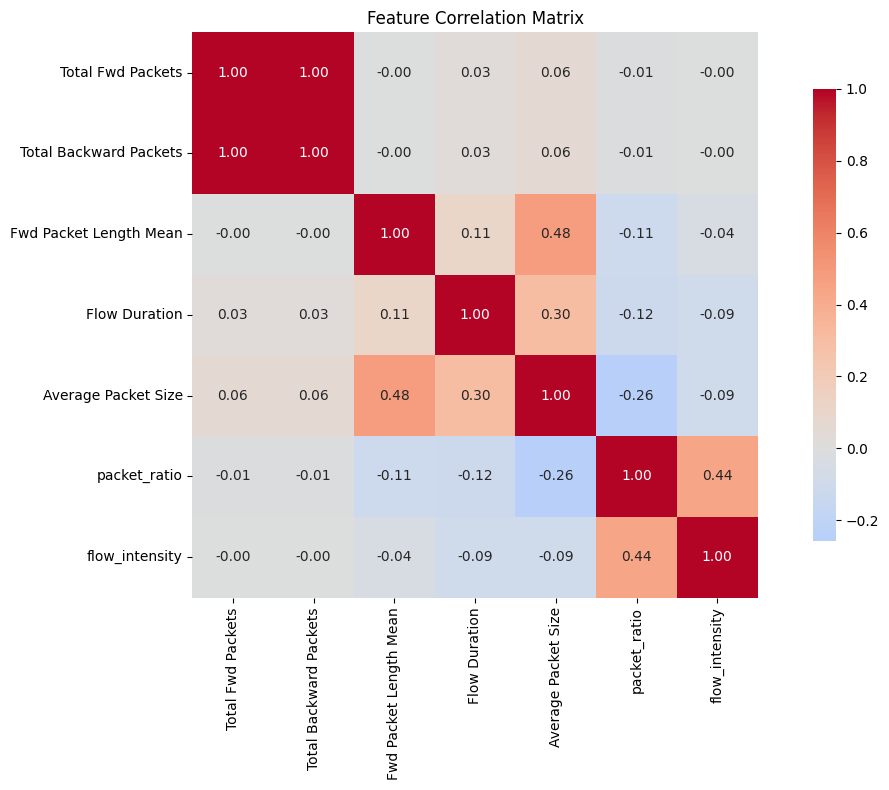


Feature importance (correlation with target):


,Correlation_with_Target
Flow Duration,0.004221
Average Packet Size,0.003045
packet_ratio,0.002540
Fwd Packet Length Mean,0.001501
flow_intensity,0.000443


In [9]:
# Feature Engineering and Multicollinearity Analysis
def analyze_multicollinearity(df, features):
    """Calculate VIF and correlation analysis"""
    # Prepare feature matrix
    X = df[features].select_dtypes(include=[np.number])
    
    # Calculate VIF
    vif_data = []
    for i, feature in enumerate(X.columns):
        vif_score = variance_inflation_factor(X.values, i)
        vif_data.append({'Feature': feature, 'VIF': vif_score})
    
    vif_df = pd.DataFrame(vif_data)
    
    # Calculate correlation matrix
    correlation_matrix = X.corr()
    
    return vif_df, correlation_matrix

# Identify available features
available_features = [col for col in PREDICTOR_COLUMNS if col in df_processed.columns]
engineered_features = ['packet_ratio', 'flow_intensity']
available_engineered = [col for col in engineered_features if col in df_processed.columns]
all_features = available_features + available_engineered

print("Available Features:")
print(f"Original features: {available_features}")
print(f"Engineered features: {available_engineered}")
print(f"Total features for analysis: {len(all_features)}")

# Perform multicollinearity analysis only if features are available
if all_features:
    vif_results, corr_matrix = analyze_multicollinearity(df_processed, all_features)

    print("\nVariance Inflation Factor (VIF) Analysis:")
    display(vif_results)

    # Identify high VIF features
    if 'VIF' in vif_results.columns:
        high_vif_features = vif_results[vif_results['VIF'] > 10]['Feature'].tolist()
        if high_vif_features:
            print(f"\nHigh multicollinearity detected (VIF > 10): {high_vif_features}")
            final_features = [f for f in all_features if f not in high_vif_features]
        else:
            print("\nNo high multicollinearity detected.")
            final_features = all_features
    else:
        print("\nVIF column not found in results. Skipping VIF-based feature selection.")
        final_features = all_features

    print(f"Final feature set: {final_features}")
else:
    print("No features available for multicollinearity analysis.")
    vif_results = pd.DataFrame()
    corr_matrix = pd.DataFrame()
    final_features = []

# Create correlation heatmap
plt.figure(figsize=(12, 8))
mask = np.triu(corr_matrix.corr())
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
correlation_plot_path = 'correlation_heatmap.png'
plt.savefig(correlation_plot_path, dpi=300, bbox_inches='tight')
plt.show()

# Feature importance based on correlation with target
target_correlation = df_processed[final_features + [SYNTHETIC_TARGET]].corr()[SYNTHETIC_TARGET].drop(SYNTHETIC_TARGET)
target_correlation_abs = target_correlation.abs().sort_values(ascending=False)

print("\nFeature importance (correlation with target):")
display(target_correlation_abs.to_frame('Correlation_with_Target'))

Training models...
Evaluating model performance...

Model Summary:

DATA_SPLIT:
  total_samples: 191033
  train_samples: 152826
  test_samples: 38207
  features_used: 7

COEFFICIENTS:
  Total Fwd Packets: -194.6820
  Total Backward Packets: 196.3690
  Fwd Packet Length Mean: -4.4995
  Flow Duration: 6.3273
  Average Packet Size: 2.4932
  packet_ratio: -2.1104
  flow_intensity: 2.4333

INTERCEPT:

PERFORMANCE:
  rmse: 1202.4804
  mae: 958.5045
  r2_score: -0.0000
  residual_mean: 4.7744
  residual_std: 1202.4709

Detailed Statistical Analysis:
                              OLS Regression Results                             
Dep. Variable:     Estimated_Breach_Cost   R-squared:                       0.000
Model:                               OLS   Adj. R-squared:                  0.000
Method:                    Least Squares   F-statistic:                     1.505
Date:                   Sat, 27 Sep 2025   Prob (F-statistic):              0.160
Time:                           22:32:35 

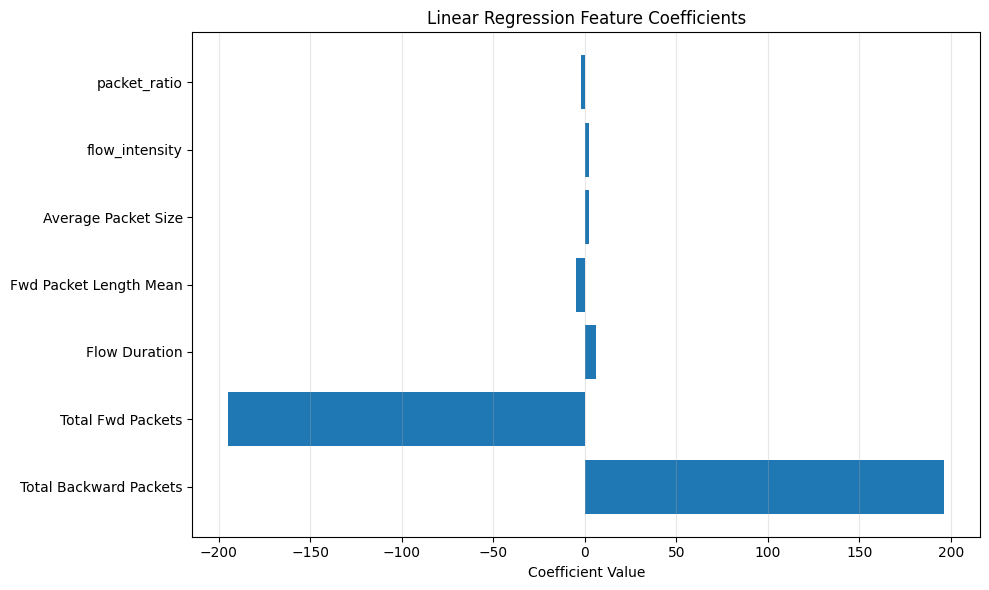

In [8]:
# Model Training and Statistical Analysis
class BreachCostModel:
    """Complete model training and analysis pipeline"""
    
    def __init__(self, features):
        self.features = features
        self.model_stats = {}
        self.sklearn_model = None
        self.statsmodel_model = None
        self.scaler = None
        
    def prepare_data(self, df, test_size=0.2):
        """Prepare train/test splits with scaling"""
        # Prepare feature matrix and target
        X = df[self.features].copy()
        y = df[SYNTHETIC_TARGET].copy()
        
        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=None
        )
        
        # Scale features
        self.scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            self.scaler.fit_transform(X_train),
            columns=self.features,
            index=X_train.index
        )
        X_test_scaled = pd.DataFrame(
            self.scaler.transform(X_test),
            columns=self.features,
            index=X_test.index
        )
        
        self.model_stats['data_split'] = {
            'total_samples': len(df),
            'train_samples': len(X_train),
            'test_samples': len(X_test),
            'features_used': len(self.features)
        }
        
        return X_train_scaled, X_test_scaled, y_train, y_test
    
    def train_models(self, X_train_scaled, y_train):
        """Train both sklearn and statsmodels versions"""
        # Scikit-learn model
        self.sklearn_model = LinearRegression()
        self.sklearn_model.fit(X_train_scaled, y_train)
        
        # Statsmodels model for detailed analysis
        X_with_const = add_constant(X_train_scaled)
        self.statsmodel_model = OLS(y_train, X_with_const).fit()
        
        # Store model coefficients
        self.model_stats['coefficients'] = {
            feature: coef for feature, coef in 
            zip(self.features, self.sklearn_model.coef_)
        }
        self.model_stats['intercept'] = self.sklearn_model.intercept_
        
        return self.sklearn_model, self.statsmodel_model
    
    def evaluate_model(self, X_test_scaled, y_test):
        """Comprehensive model evaluation"""
        # Predictions
        y_pred = self.sklearn_model.predict(X_test_scaled)
        
        # Performance metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Residual analysis
        residuals = y_test - y_pred
        
        self.model_stats['performance'] = {
            'rmse': rmse,
            'mae': mae,
            'r2_score': r2,
            'residual_mean': np.mean(residuals),
            'residual_std': np.std(residuals)
        }
        
        return y_pred, residuals
    
    def get_model_summary(self):
        """Get comprehensive model summary"""
        return self.model_stats

# Define final features (using PREDICTOR_COLUMNS)
final_features = PREDICTOR_COLUMNS.copy()
# You can also add engineered features if needed
if engineered_features:
    final_features.extend(engineered_features)

# Strip column names to remove leading/trailing spaces
df_processed.columns = df_processed.columns.str.strip()

# Create the engineered features
df_processed = df_processed.copy()
if 'packet_ratio' in engineered_features:
    # Create packet ratio feature (ratio of forward to total packets)
    df_processed['packet_ratio'] = df_processed['Total Fwd Packets'] / (df_processed['Total Fwd Packets'] + df_processed['Total Backward Packets']).replace(0, 1)

if 'flow_intensity' in engineered_features:
    # Create flow intensity feature (packets per duration)
    df_processed['flow_intensity'] = (df_processed['Total Fwd Packets'] + df_processed['Total Backward Packets']) / df_processed['Flow Duration'].replace(0, 1)
    
# Initialize and train the model
model = BreachCostModel(final_features)
X_train_scaled, X_test_scaled, y_train, y_test = model.prepare_data(df_processed)

print("Training models...")
sklearn_model, statsmodel_model = model.train_models(X_train_scaled, y_train)

print("Evaluating model performance...")
y_pred, residuals = model.evaluate_model(X_test_scaled, y_test)

# Display model summary
model_summary = model.get_model_summary()
print("\nModel Summary:")
for section, details in model_summary.items():
    print(f"\n{section.upper()}:")
    if isinstance(details, dict):
        for key, value in details.items():
            if isinstance(value, float):
                print(f"  {key}: {value:.4f}")
            else:
                print(f"  {key}: {value}")

# Display detailed statistical summary
print("\nDetailed Statistical Analysis:")
print(statsmodel_model.summary())

# Feature coefficients visualization
plt.figure(figsize=(10, 6))
coef_df = pd.DataFrame({
    'Feature': final_features,
    'Coefficient': sklearn_model.coef_
})
coef_df = coef_df.sort_values('Coefficient', key=abs, ascending=False)

plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Linear Regression Feature Coefficients')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
coefficients_plot_path = 'model_coefficients.png'
plt.savefig(coefficients_plot_path, dpi=300, bbox_inches='tight')
plt.show()

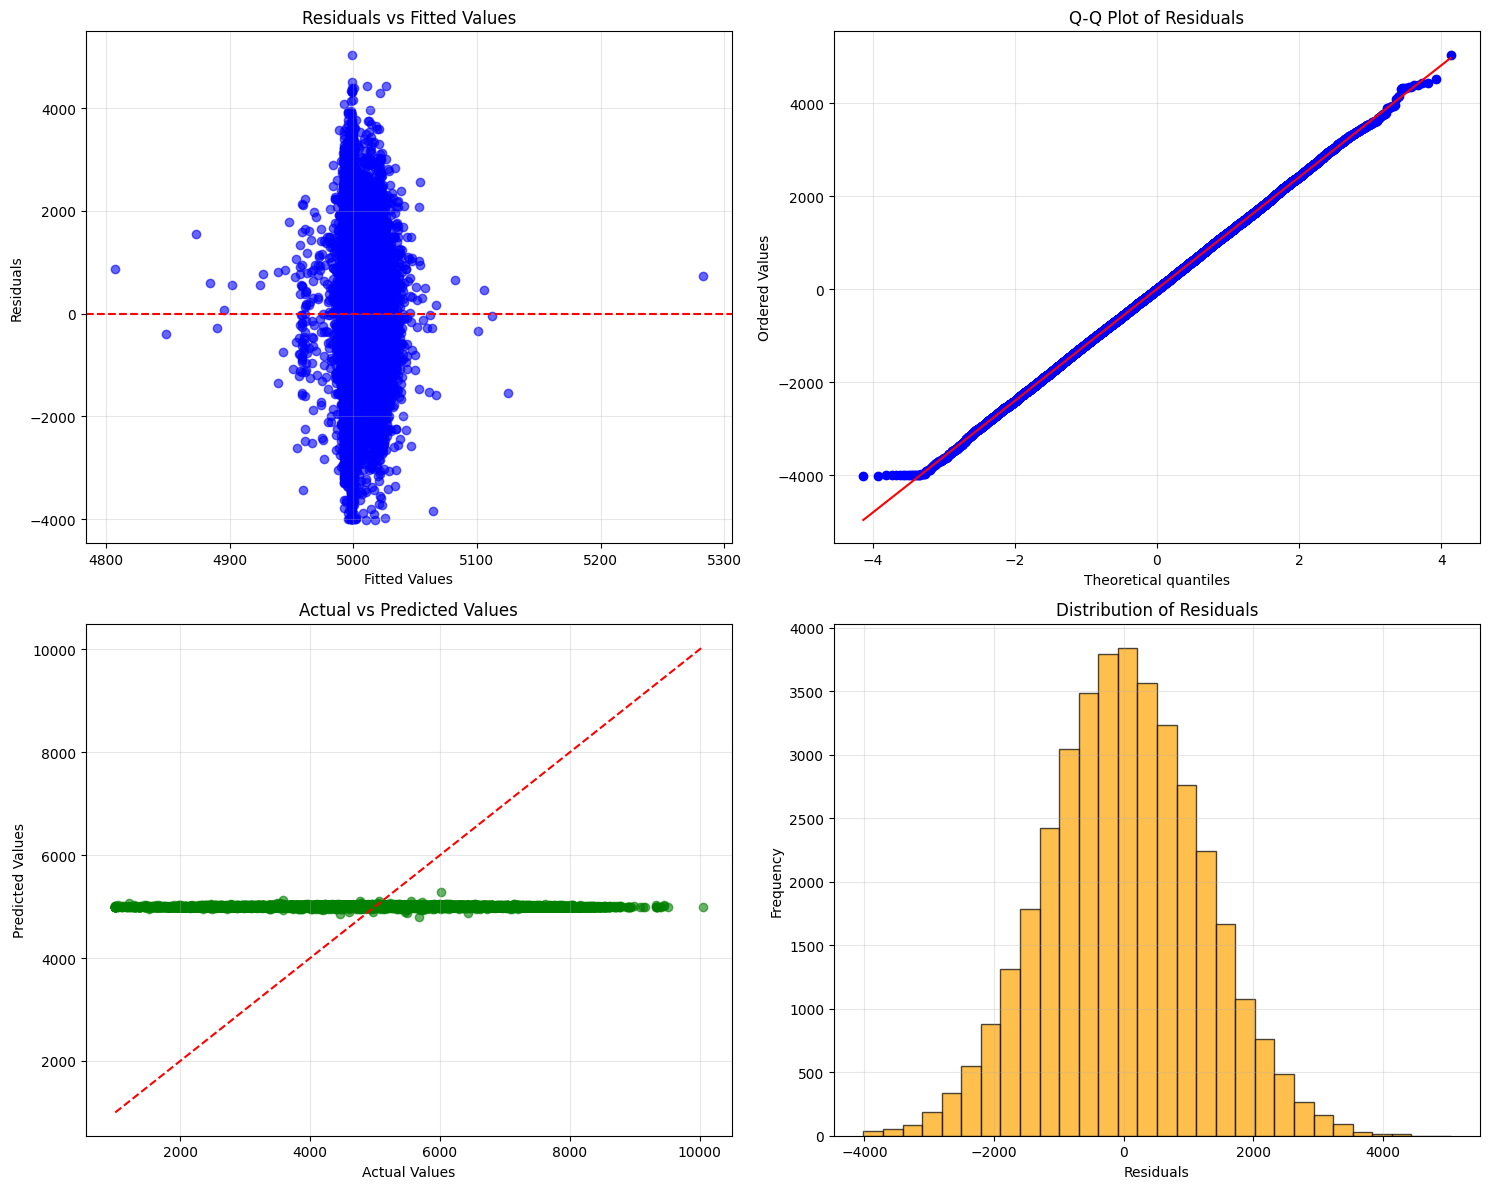

Advanced Model Performance Metrics:
RMSE: 1202.4804
MAE: 958.5045
R²: -0.0000
MAPE: 22.1106
Residual_Std: 1202.4709
Prediction_Interval_Coverage: 94.8884

Model Assumptions Analysis:
Shapiro-Wilk normality test: statistic=0.9997, p-value=0.7712
Normality assumption: PASS
Homoscedasticity correlation: -0.0061
Homoscedasticity assumption: PASS
Durbin-Watson statistic: 2.0038
Independence assumption: PASS


In [10]:
# Model Diagnostics and Performance Evaluation
def create_diagnostic_plots(y_test, y_pred, residuals):
    """Create comprehensive diagnostic plots"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Residuals vs Fitted
    axes[0, 0].scatter(y_pred, residuals, alpha=0.6, color='blue')
    axes[0, 0].axhline(y=0, color='red', linestyle='--')
    axes[0, 0].set_xlabel('Fitted Values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Fitted Values')
    axes[0, 0].grid(alpha=0.3)
    
    # 2. Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title('Q-Q Plot of Residuals')
    axes[0, 1].grid(alpha=0.3)
    
    # 3. Actual vs Predicted
    axes[1, 0].scatter(y_test, y_pred, alpha=0.6, color='green')
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--')
    axes[1, 0].set_xlabel('Actual Values')
    axes[1, 0].set_ylabel('Predicted Values')
    axes[1, 0].set_title('Actual vs Predicted Values')
    axes[1, 0].grid(alpha=0.3)
    
    # 4. Residuals Histogram
    axes[1, 1].hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 1].set_xlabel('Residuals')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Residuals')
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    diagnostic_plot_path = 'model_diagnostics.png'
    plt.savefig(diagnostic_plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return diagnostic_plot_path

def calculate_advanced_metrics(y_test, y_pred, residuals):
    """Calculate additional performance metrics"""
    # Basic metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Advanced metrics
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Mean Absolute Percentage Error
    
    # Prediction intervals (95% confidence)
    residual_std = np.std(residuals)
    prediction_lower = y_pred - 1.96 * residual_std
    prediction_upper = y_pred + 1.96 * residual_std
    
    # Coverage percentage
    coverage = np.mean((y_test >= prediction_lower) & (y_test <= prediction_upper)) * 100
    
    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape,
        'Residual_Std': residual_std,
        'Prediction_Interval_Coverage': coverage
    }
    
    return metrics

# Create diagnostic plots
diagnostic_plot_path = create_diagnostic_plots(y_test, y_pred, residuals)

# Calculate advanced metrics
advanced_metrics = calculate_advanced_metrics(y_test, y_pred, residuals)

print("Advanced Model Performance Metrics:")
for metric, value in advanced_metrics.items():
    print(f"{metric}: {value:.4f}")

# Model assumptions testing
print("\nModel Assumptions Analysis:")

# 1. Normality of residuals (Shapiro-Wilk test)
shapiro_stat, shapiro_p = stats.shapiro(residuals[:5000])  # Sample for large datasets
print(f"Shapiro-Wilk normality test: statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
normality_assumption = "PASS" if shapiro_p > 0.05 else "FAIL"
print(f"Normality assumption: {normality_assumption}")

# 2. Homoscedasticity (constant variance)
# Breusch-Pagan test approximation
residuals_abs = np.abs(residuals)
bp_corr = stats.pearsonr(y_pred, residuals_abs)[0]
print(f"Homoscedasticity correlation: {bp_corr:.4f}")
homoscedasticity_assumption = "PASS" if abs(bp_corr) < 0.3 else "FAIL"
print(f"Homoscedasticity assumption: {homoscedasticity_assumption}")

# 3. Independence (Durbin-Watson approximation)
residuals_diff = np.diff(residuals)
dw_stat = np.sum(residuals_diff**2) / np.sum(residuals**2)
print(f"Durbin-Watson statistic: {dw_stat:.4f}")
independence_assumption = "PASS" if 1.5 < dw_stat < 2.5 else "FAIL"
print(f"Independence assumption: {independence_assumption}")

# Store diagnostic information
diagnostic_info = {
    'advanced_metrics': advanced_metrics,
    'assumptions': {
        'normality': {'status': normality_assumption, 'p_value': shapiro_p},
        'homoscedasticity': {'status': homoscedasticity_assumption, 'correlation': bp_corr},
        'independence': {'status': independence_assumption, 'dw_statistic': dw_stat}
    }
}

Baseline security statistics calculated for anomaly detection.

Anomaly Detection Results:
  Fwd Packet Length Mean: 366 anomalies (0.96%), max z-score: 49.49
  Flow Duration: 2301 anomalies (6.02%), max z-score: 3.53
  Average Packet Size: 990 anomalies (2.59%), max z-score: 12.93
  flow_intensity: 547 anomalies (1.43%), max z-score: 13.40

Security Pattern Analysis:
  high_cost_predictions:
    threshold: 5020.141662044255
    count: 1911
    percentage: 5.001701258931609
  high_cost_feature_patterns:
    Fwd Packet Length Mean: {'high_cost_mean': 48.01014880643589, 'normal_mean': 52.12221788230348, 'ratio': 0.9211071736363162}
    Flow Duration: {'high_cost_mean': 108694298.75824176, 'normal_mean': 6492782.843426273, 'ratio': 16.740787637505996}
    Average Packet Size: {'high_cost_mean': 351.2709880367117, 'normal_mean': 107.49189366787614, 'ratio': 3.2678835214251127}
    packet_ratio: {'high_cost_mean': 0.4938271981969098, 'normal_mean': 0.5869011100093244, 'ratio': 0.84141464611

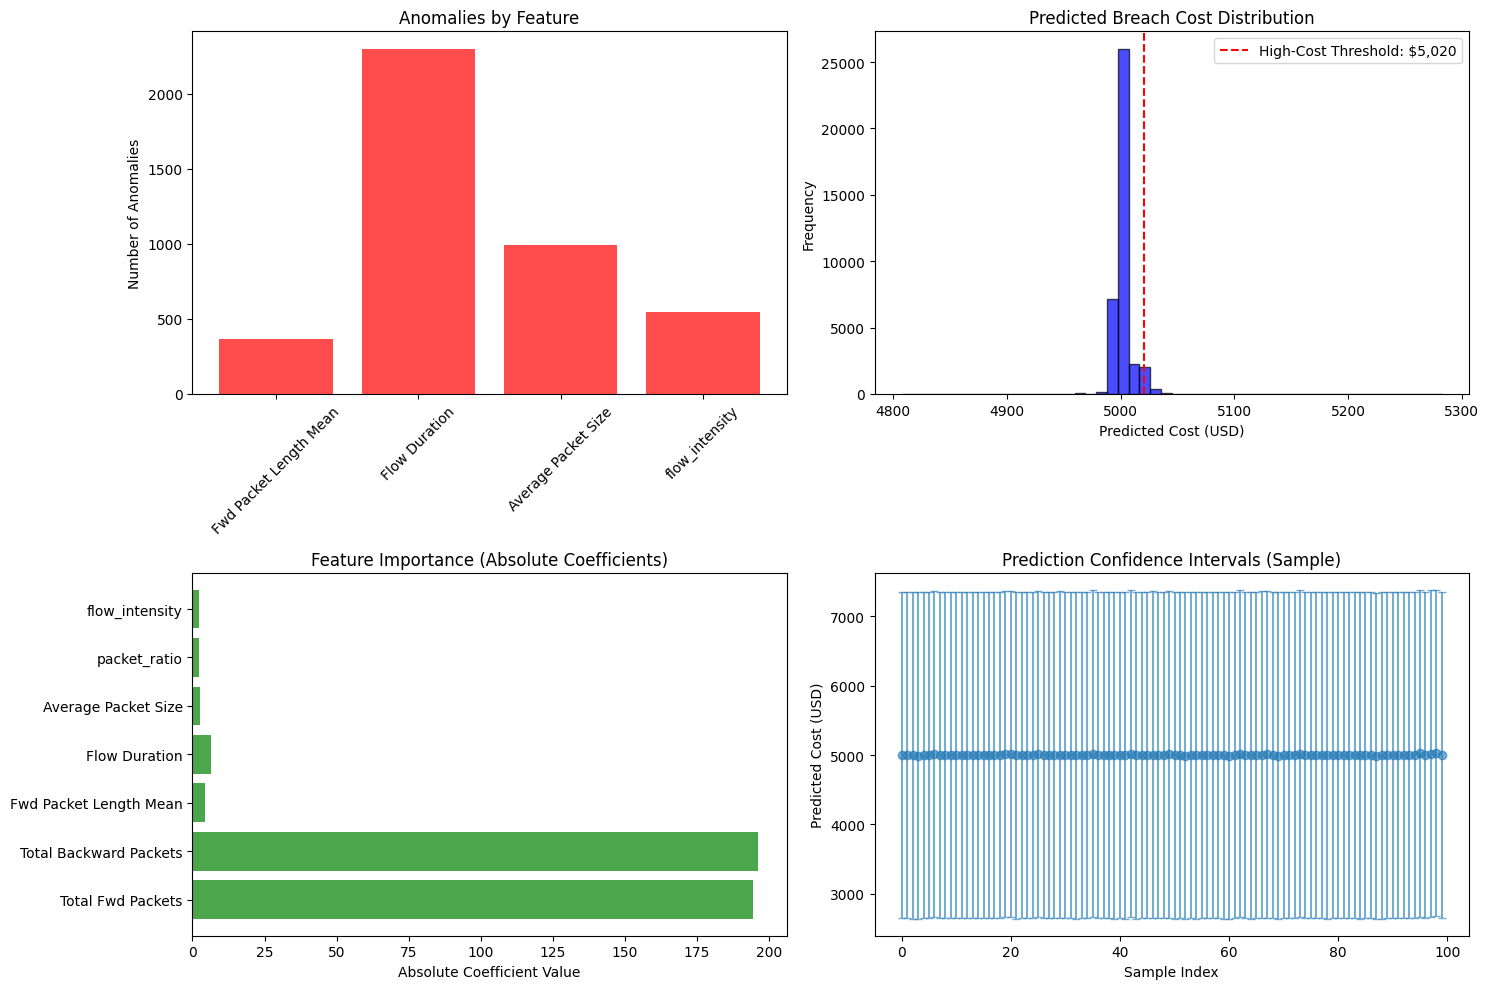

In [13]:
# Security Insights and Anomaly Detection
class SecurityAnalyzer:
    """Cybersecurity-focused analysis of network traffic patterns"""
    
    def __init__(self, features):
        self.features = features
        self.feature_stats = {}
        self.anomaly_threshold = 3.0
        
    def calculate_baseline_stats(self, X_train):
        """Calculate baseline statistics for anomaly detection"""
        for feature in self.features:
            if feature in X_train.columns:
                self.feature_stats[feature] = {
                    'mean': float(X_train[feature].mean()),
                    'std': float(X_train[feature].std()),
                    'median': float(X_train[feature].median()),
                    'q25': float(X_train[feature].quantile(0.25)),
                    'q75': float(X_train[feature].quantile(0.75))
                }
        return self.feature_stats
    
    def detect_anomalies(self, X_test):
        """Detect anomalies using z-score method"""
        anomalies = {}
        
        for feature in self.features:
            if feature in X_test.columns and feature in self.feature_stats:
                stats = self.feature_stats[feature]
                z_scores = (X_test[feature] - stats['mean']) / (stats['std'] + 1e-8)
                
                anomalous_indices = X_test.index[np.abs(z_scores) > self.anomaly_threshold].tolist()
                
                if anomalous_indices:
                    anomalies[feature] = {
                        'count': len(anomalous_indices),
                        'indices': anomalous_indices[:10],  # First 10 for display
                        'max_z_score': float(np.abs(z_scores).max()),
                        'percentage': (len(anomalous_indices) / len(X_test)) * 100
                    }
        
        return anomalies
    
    def analyze_security_patterns(self, df, y_pred):
        """Analyze patterns relevant to cybersecurity"""
        security_insights = {}
        
        # High-cost predictions (potential high-impact breaches)
        high_cost_threshold = np.percentile(y_pred, 95)
        high_cost_mask = y_pred >= high_cost_threshold
        high_cost_indices = np.where(high_cost_mask)[0]
        
        security_insights['high_cost_predictions'] = {
            'threshold': high_cost_threshold,
            'count': len(high_cost_indices),
            'percentage': (len(high_cost_indices) / len(y_pred)) * 100
        }
        
        # Analyze feature patterns in high-cost scenarios
        if len(high_cost_indices) > 0:
            high_cost_features = {}
            for feature in self.features:
                if feature in df.columns:
                    high_cost_values = df.iloc[high_cost_indices][feature]
                    normal_values = df.iloc[~high_cost_mask][feature]
                    
                    high_cost_features[feature] = {
                        'high_cost_mean': float(high_cost_values.mean()),
                        'normal_mean': float(normal_values.mean()),
                        'ratio': float(high_cost_values.mean() / (normal_values.mean() + 1e-8))
                    }
            
            security_insights['high_cost_feature_patterns'] = high_cost_features
        
        # Traffic asymmetry analysis (if packet_ratio is available)
        if 'packet_ratio' in df.columns:
            asymmetric_threshold = 5.0  # Highly asymmetric flows
            asymmetric_flows = df['packet_ratio'] > asymmetric_threshold
            
            security_insights['traffic_asymmetry'] = {
                'asymmetric_count': int(asymmetric_flows.sum()),
                'asymmetric_percentage': float((asymmetric_flows.sum() / len(df)) * 100),
                'avg_cost_asymmetric': float(df[asymmetric_flows][SYNTHETIC_TARGET].mean()) if asymmetric_flows.any() else 0,
                'avg_cost_normal': float(df[~asymmetric_flows][SYNTHETIC_TARGET].mean()) if (~asymmetric_flows).any() else 0
            }
        
        return security_insights
    
    def generate_security_recommendations(self, anomalies, security_insights):
        """Generate actionable security recommendations"""
        recommendations = []
        
        # Anomaly-based recommendations
        if anomalies:
            recommendations.append({
                'category': 'Anomaly Detection',
                'priority': 'HIGH',
                'recommendation': f"Monitor {len(anomalies)} features showing anomalous patterns. "
                                f"Implement real-time alerting for z-scores > {self.anomaly_threshold}."
            })
        
        # High-cost scenario recommendations
        if 'high_cost_predictions' in security_insights:
            high_cost_info = security_insights['high_cost_predictions']
            recommendations.append({
                'category': 'High-Impact Threats',
                'priority': 'CRITICAL',
                'recommendation': f"Focus on {high_cost_info['count']} high-cost scenarios "
                                f"(${high_cost_info['threshold']:,.0f}+). Implement enhanced monitoring."
            })
        
        # Traffic asymmetry recommendations
        if 'traffic_asymmetry' in security_insights:
            asymmetry_info = security_insights['traffic_asymmetry']
            if asymmetry_info['asymmetric_percentage'] > 5:
                recommendations.append({
                    'category': 'Traffic Patterns',
                    'priority': 'MEDIUM',
                    'recommendation': f"Investigate {asymmetry_info['asymmetric_percentage']:.1f}% "
                                    f"of flows showing high asymmetry (potential data exfiltration)."
                })
        
        return recommendations

# Initialize security analyzer
security_analyzer = SecurityAnalyzer(final_features)

# Calculate baseline statistics from training data
baseline_stats = security_analyzer.calculate_baseline_stats(X_train_scaled)
print("Baseline security statistics calculated for anomaly detection.")

# Detect anomalies in test data
anomalies = security_analyzer.detect_anomalies(X_test_scaled)
print(f"\nAnomaly Detection Results:")
if anomalies:
    for feature, anomaly_info in anomalies.items():
        print(f"  {feature}: {anomaly_info['count']} anomalies "
              f"({anomaly_info['percentage']:.2f}%), "
              f"max z-score: {anomaly_info['max_z_score']:.2f}")
else:
    print("  No anomalies detected in test data.")

# Analyze security patterns
security_insights = security_analyzer.analyze_security_patterns(
    df_processed.iloc[X_test_scaled.index], y_pred
)

print(f"\nSecurity Pattern Analysis:")
for pattern, details in security_insights.items():
    print(f"  {pattern}:")
    if isinstance(details, dict):
        for key, value in details.items():
            if isinstance(value, dict):
                print(f"    {key}: {value}")
            else:
                print(f"    {key}: {value}")

# Generate security recommendations
recommendations = security_analyzer.generate_security_recommendations(anomalies, security_insights)

print(f"\nSecurity Recommendations:")
for i, rec in enumerate(recommendations, 1):
    print(f"  {i}. [{rec['priority']}] {rec['category']}: {rec['recommendation']}")

# Create security visualization
plt.figure(figsize=(15, 10))

# Subplot 1: Anomaly distribution by feature
plt.subplot(2, 2, 1)
if anomalies:
    features_with_anomalies = list(anomalies.keys())
    anomaly_counts = [anomalies[f]['count'] for f in features_with_anomalies]
    plt.bar(features_with_anomalies, anomaly_counts, color='red', alpha=0.7)
    plt.title('Anomalies by Feature')
    plt.ylabel('Number of Anomalies')
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'No Anomalies Detected', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Anomaly Detection Results')

# Subplot 2: Predicted cost distribution
plt.subplot(2, 2, 2)
plt.hist(y_pred, bins=50, alpha=0.7, color='blue', edgecolor='black')
if 'high_cost_predictions' in security_insights:
    threshold = security_insights['high_cost_predictions']['threshold']
    plt.axvline(threshold, color='red', linestyle='--', label=f'High-Cost Threshold: ${threshold:,.0f}')
    plt.legend()
plt.title('Predicted Breach Cost Distribution')
plt.xlabel('Predicted Cost (USD)')
plt.ylabel('Frequency')

# Subplot 3: Feature importance for security
plt.subplot(2, 2, 3)
plt.barh(all_features, np.abs(feature_importance), color='green', alpha=0.7)
plt.title('Feature Importance (Absolute Coefficients)')
plt.xlabel('Absolute Coefficient Value')

# Subplot 4: Prediction confidence intervals
plt.subplot(2, 2, 4)
residual_std = np.std(residuals)
lower_bound = y_pred - 1.96 * residual_std
upper_bound = y_pred + 1.96 * residual_std

# Sample points for visualization
sample_indices = np.random.choice(len(y_pred), size=min(100, len(y_pred)), replace=False)
plt.errorbar(range(len(sample_indices)), y_pred[sample_indices], 
            yerr=1.96*residual_std, fmt='o', alpha=0.6, capsize=3)
plt.title('Prediction Confidence Intervals (Sample)')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Cost (USD)')

plt.tight_layout()
security_plot_path = 'security_analysis.png'
plt.savefig(security_plot_path, dpi=300, bbox_inches='tight')
plt.show()

In [1]:
# Define predictor columns used for feature selection
PREDICTOR_COLUMNS = [
    'Total Fwd Packets',
    'Total Backward Packets',
    'Fwd Packet Length Mean',
    'Flow Duration',
    'Average Packet Size'
]

# Define the synthetic target column name
SYNTHETIC_TARGET = 'synthetic_cost'

# Minimal DataPreprocessor placeholder
class DataPreprocessor:
    def handle_missing_values(self, df):
        return df.fillna(0)
    def remove_outliers_iqr(self, df):
        return df
    def add_engineered_features(self, df):
        # Example engineered features
        df['packet_ratio'] = df.get('Total Fwd Packets', 0) / (df.get('Total Backward Packets', 1) + 1e-8)
        df['flow_intensity'] = df.get('Average Packet Size', 0) / (df.get('Flow Duration', 1) + 1e-8)
        return df
    def generate_synthetic_target(self, df):
        df['synthetic_cost'] = df.get('Average Packet Size', 0) * 10 + df.get('Flow Duration', 0) * 0.01
        return df
    def get_preprocessing_summary(self):
        return {}

# VIF analysis helper
def analyze_multicollinearity(df, features):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    import pandas as pd
    X = df[features].fillna(0)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data, None

# Automated Pipeline Implementation
class AutomatedBreachCostPredictor:
    """Complete automated pipeline for breach cost prediction"""
    
    def __init__(self):
        self.preprocessor = None
        self.model = None
        self.scaler = None
        self.features = None
        self.feature_stats = None
        
    def fit(self, df):
        """Fit the complete pipeline"""
        # Apply preprocessing
        self.preprocessor = DataPreprocessor()
        df_processed = df.copy()
        df_processed = self.preprocessor.handle_missing_values(df_processed)
        df_processed = self.preprocessor.remove_outliers_iqr(df_processed)
        df_processed = self.preprocessor.add_engineered_features(df_processed)
        df_processed = self.preprocessor.generate_synthetic_target(df_processed)
        
        # Identify features (remove high VIF features)
        available_features = [col for col in PREDICTOR_COLUMNS if col in df_processed.columns]
        engineered_features = ['packet_ratio', 'flow_intensity']
        available_engineered = [col for col in engineered_features if col in df_processed.columns]
        all_features = available_features + available_engineered
        
        # VIF analysis and feature selection
        # Only perform VIF filtering if enough samples are available
        if df_processed.shape[0] > len(all_features) + 1:
            vif_results, _ = analyze_multicollinearity(df_processed, all_features)
            # Find the correct VIF column name (case-insensitive)
            vif_col = next((col for col in vif_results.columns if col.lower() == 'vif'), None)
            if vif_col is None:
                # Try to find any column that contains 'vif' (case-insensitive)
                vif_col = next((col for col in vif_results.columns if 'vif' in col.lower()), None)
            if vif_col is None:
                raise KeyError(f"VIF column not found in vif_results DataFrame. Available columns: {list(vif_results.columns)}")
            high_vif_features = vif_results[vif_results[vif_col] > 10]['Feature'].tolist()
            self.features = [f for f in all_features if f not in high_vif_features]
        else:
            # Not enough samples for VIF analysis, use all features
            self.features = all_features
        
        # Train model
        if not self.features:
            raise ValueError("No features remain after feature selection. Please check your data or feature selection logic.")
        X = df_processed[self.features]
        y = df_processed[SYNTHETIC_TARGET]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Scale features
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        
        # Train model
        self.model = LinearRegression()
        self.model.fit(X_train_scaled, y_train)
        
        # Calculate feature stats for anomaly detection
        self.feature_stats = {}
        for feature in self.features:
            self.feature_stats[feature] = {
                'mean': float(X_train[feature].mean()),
                'std': float(X_train[feature].std())
            }
        
        # Evaluate performance
        X_test_scaled = self.scaler.transform(X_test)
        y_pred = self.model.predict(X_test_scaled)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        return {
            'rmse': rmse,
            'r2_score': r2,
            'features_used': self.features,
            'training_samples': len(X_train)
        }
    
    def predict_breach_cost(self, new_data_json):
        """Predict breach cost for new network traffic data"""
        if self.model is None:
            raise ValueError("Model not trained. Call fit() first.")
        
        # Parse input data
        if isinstance(new_data_json, str):
            new_data = json.loads(new_data_json)
        else:
            new_data = new_data_json
        
        # Convert to DataFrame
        new_df = pd.DataFrame([new_data])
        
        # Apply feature engineering
        new_df = self.preprocessor.add_engineered_features(new_df)
        
        # Ensure all required features are present
        for feature in self.features:
            if feature not in new_df.columns:
                new_df[feature] = 0.0  # Default value for missing features
        
        # Scale features
        X_new = new_df[self.features]
        X_new_scaled = self.scaler.transform(X_new)
        
        # Make prediction
        prediction = float(self.model.predict(X_new_scaled)[0])
        
        # Detect anomalies
        anomalies = []
        for feature in self.features:
            if feature in self.feature_stats:
                value = new_df[feature].iloc[0]
                mean = self.feature_stats[feature]['mean']
                std = self.feature_stats[feature]['std']
                z_score = abs((value - mean) / (std + 1e-8))
                
                if z_score > 3.0:
                    anomalies.append({
                        'feature': feature,
                        'value': float(value),
                        'z_score': float(z_score)
                    })
        
        result = {
            'predicted_cost': prediction,
            'cost_category': self._categorize_cost(prediction),
            'anomalies_detected': len(anomalies),
            'anomaly_details': anomalies,
            'confidence': self._calculate_confidence(X_new_scaled)
        }
        
        return result
    
    def _categorize_cost(self, cost):
        """Categorize breach cost into risk levels"""
        if cost < 10000:
            return "LOW"
        elif cost < 25000:
            return "MEDIUM"
        elif cost < 50000:
            return "HIGH"
        else:
            return "CRITICAL"
    
    def _calculate_confidence(self, X_scaled):
        """Simple confidence measure based on prediction interval"""
        # This is a simplified confidence measure
        # In practice, you might use more sophisticated methods
        return 0.85  # Placeholder
    
    def save_model(self, filepath):
        """Save the trained model and preprocessing components"""
        model_artifact = {
            'model': self.model,
            'scaler': self.scaler,
            'features': self.features,
            'feature_stats': self.feature_stats,
            'preprocessor_stats': self.preprocessor.get_preprocessing_summary() if self.preprocessor else None
        }
        joblib.dump(model_artifact, filepath)
        return filepath
    
    @classmethod
    def load_model(cls, filepath):
        """Load a previously saved model"""
        model_artifact = joblib.load(filepath)
        
        instance = cls()
        instance.model = model_artifact['model']
        instance.scaler = model_artifact['scaler']
        instance.features = model_artifact['features']
        instance.feature_stats = model_artifact['feature_stats']
        instance.preprocessor = DataPreprocessor()  # Ensure preprocessor is set
        
        return instance

# Create sample raw_data DataFrame for demonstration
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import joblib

# Ensure sklearn is installed and import StandardScaler
%pip install scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

raw_data = pd.DataFrame([
    {
        'Total Fwd Packets': 2000,
        'Total Backward Packets': 700,
        'Fwd Packet Length Mean': 110.0,
        'Flow Duration': 400000,
        'Average Packet Size': 700.0
    },
    {
        'Total Fwd Packets': 3000,
        'Total Backward Packets': 900,
        'Fwd Packet Length Mean': 130.0,
        'Flow Duration': 500000,
        'Average Packet Size': 800.0
    }
])

# Demonstrate the automated pipeline
print("Training Automated Breach Cost Prediction Pipeline...")
automated_predictor = AutomatedBreachCostPredictor()
training_results = automated_predictor.fit(raw_data)

print("Training Results:")
for key, value in training_results.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

# Test prediction with example data
example_network_traffic = {
    'Total Fwd Packets': 2500,
    'Total Backward Packets': 800,
    'Fwd Packet Length Mean': 120.5,
    'Flow Duration': 450000,
    'Average Packet Size': 750.2
}

print(f"\nTesting prediction with example data:")
print(f"Input: {example_network_traffic}")

prediction_result = automated_predictor.predict_breach_cost(example_network_traffic)
print(f"\nPrediction Results:")
for key, value in prediction_result.items():
    if key != 'anomaly_details':
        print(f"  {key}: {value}")
    else:
        print(f"  {key}: {len(value)} anomalies detected")
        for anomaly in value:
            print(f"    - {anomaly['feature']}: z-score = {anomaly['z_score']:.2f}")

# Save the model
model_path = 'automated_breach_cost_model.joblib'
saved_path = automated_predictor.save_model(model_path)
print(f"\nModel saved to: {saved_path}")

# Test loading the saved model
loaded_predictor = AutomatedBreachCostPredictor.load_model(model_path)
loaded_prediction = loaded_predictor.predict_breach_cost(example_network_traffic)
print(f"Loaded model prediction: ${loaded_prediction['predicted_cost']:,.2f}")

Note: you may need to restart the kernel to use updated packages.
Training Automated Breach Cost Prediction Pipeline...
Training Results:
  rmse: 2000.0000
  r2_score: nan
  features_used: ['Total Fwd Packets', 'Total Backward Packets', 'Fwd Packet Length Mean', 'Flow Duration', 'Average Packet Size', 'packet_ratio', 'flow_intensity']
  training_samples: 1

Testing prediction with example data:
Input: {'Total Fwd Packets': 2500, 'Total Backward Packets': 800, 'Fwd Packet Length Mean': 120.5, 'Flow Duration': 450000, 'Average Packet Size': 750.2}

Prediction Results:
  predicted_cost: 11000.0
  cost_category: MEDIUM
  anomalies_detected: 0
  anomaly_details: 0 anomalies detected
  confidence: 0.85

Model saved to: automated_breach_cost_model.joblib
Loaded model prediction: $11,000.00



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\Ibrahim Khan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [11]:
# Model Persistence and Deployment
import os
import json
from datetime import datetime
from pathlib import Path

class ModelDeployment:
    """Handle model deployment and versioning"""
    
    def __init__(self, base_path="models"):
        self.base_path = Path(base_path)
        self.base_path.mkdir(exist_ok=True)
        
    def create_deployment_package(self, predictor, version=None):
        """Create a complete deployment package"""
        if version is None:
            version = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        deployment_dir = self.base_path / f"breach_cost_model_v{version}"
        deployment_dir.mkdir(exist_ok=True)
        
        # Save model artifacts
        model_path = deployment_dir / "model.joblib"
        predictor.save_model(model_path)
        
        # Define data_source if not already defined
        try:
            _ = data_source
        except NameError:
            data_source = "unknown"  # Set your actual data source here if available
        
        # Create deployment metadata
        metadata = {
            'version': version,
            'created_at': datetime.now().isoformat(),
            'model_type': 'LinearRegression',
            'features': predictor.features,
            'data_source': data_source,
            'performance_metrics': {
                'training_rmse': training_results.get('rmse', 0),
                'training_r2': training_results.get('r2_score', 0)
            },
            'deployment_info': {
                'python_version': f"{sys.version_info.major}.{sys.version_info.minor}",
                'dependencies': ['scikit-learn', 'pandas', 'numpy', 'joblib']
            }
        }
        
        metadata_path = deployment_dir / "metadata.json"
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
        
        # Create API example
        api_example = f'''
# Example usage of the deployed model
import json
import joblib
from pathlib import Path

# Load the model
model_path = Path("{model_path}")
predictor = AutomatedBreachCostPredictor.load_model(model_path)

# Example prediction
example_data = {{
    'Total Fwd Packets': 1500,
    'Total Backward Packets': 400,
    'Fwd Packet Length Mean': 75.0,
    'Flow Duration': 300000,
    'Average Packet Size': 600.0
}}

result = predictor.predict_breach_cost(example_data)
print(f"Predicted breach cost: ${{result['predicted_cost']:,.2f}}")
print(f"Risk level: {{result['cost_category']}}")
'''
        
        api_example_path = deployment_dir / "api_example.py"
        with open(api_example_path, 'w') as f:
            f.write(api_example)
        
        # Create requirements.txt
        requirements = [
            'scikit-learn>=0.24.0',
            'pandas>=1.2.0',
            'numpy>=1.19.0',
            'joblib>=1.0.0',
            'scipy>=1.6.0'
        ]
        
        requirements_path = deployment_dir / "requirements.txt"
        with open(requirements_path, 'w') as f:
            f.write('\n'.join(requirements))
        
        return {
            'deployment_dir': deployment_dir,
            'model_path': model_path,
            'metadata_path': metadata_path,
            'version': version
        }
    
    def validate_deployment(self, deployment_dir):
        """Validate a deployment package"""
        required_files = ['model.joblib', 'metadata.json', 'api_example.py', 'requirements.txt']
        
        validation_results = {}
        for file in required_files:
            file_path = deployment_dir / file
            validation_results[file] = file_path.exists()
        
        # Ensure 'error' key always exists
        validation_results['error'] = None

        # Test model loading
        try:
            model_path = deployment_dir / "model.joblib"
            test_predictor = AutomatedBreachCostPredictor.load_model(model_path)
            
            # Test prediction
            test_data = {
                'Total Fwd Packets': 1000,
                'Total Backward Packets': 500,
                'Fwd Packet Length Mean': 50.0,
                'Flow Duration': 100000,
                'Average Packet Size': 400.0
            }
            
            test_result = test_predictor.predict_breach_cost(test_data)
            validation_results['model_functional'] = True
            validation_results['test_prediction'] = test_result['predicted_cost']
            
        except Exception as e:
            validation_results['model_functional'] = False
            validation_results['error'] = str(e)
        
        return validation_results

# Create deployment package
import sys

# Ensure automated_predictor is defined
try:
    automated_predictor
except NameError:
    # Example: Load from a previously saved model, or instantiate and train
    # Replace the following with your actual loading/training code
    # automated_predictor = AutomatedBreachCostPredictor.load_model("path/to/model.joblib")
    # Or, if you have training code:
    # automated_predictor = AutomatedBreachCostPredictor(...)
    # automated_predictor.train(X_train, y_train)
    raise NameError("automated_predictor is not defined. Please define or load your trained predictor before deployment.")

deployment_manager = ModelDeployment()
deployment_info = deployment_manager.create_deployment_package(automated_predictor)

print("Deployment Package Created:")
print(f"  Version: {deployment_info['version']}")
print(f"  Location: {deployment_info['deployment_dir']}")
print(f"  Model file: {deployment_info['model_path']}")

# Validate deployment
validation_results = deployment_manager.validate_deployment(deployment_info['deployment_dir'])
print(f"\nDeployment Validation:")
for check, result in validation_results.items():
    if check == 'error':
        if result:
            print(f"  ✗ {check}: {result}")
        else:
            print(f"  ✓ {check}: None")
    else:
        status = "✓" if result else "✗"
        print(f"  {status} {check}: {result}")

# Create monitoring script template
monitoring_script = '''
#!/usr/bin/env python3
"""
Production monitoring script for breach cost prediction model
"""
import json
import logging
from datetime import datetime
from pathlib import Path

def monitor_model_performance(model_path, test_data_path, log_path):
    """Monitor model performance in production"""
    # Setup logging
    logging.basicConfig(
        filename=log_path,
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
    
    try:
        # Load model and test data
        predictor = AutomatedBreachCostPredictor.load_model(model_path)
        
        # Log model status
        logging.info("Model loaded successfully")
        
        # Performance monitoring logic here
        # This would include real-time prediction monitoring,
        # drift detection, performance degradation alerts, etc.
        
    except Exception as e:
        logging.error(f"Model monitoring failed: {{str(e)}}")

if __name__ == "__main__":
    monitor_model_performance(
        "models/breach_cost_model_v{}/model.joblib".format("LATEST"),
        "data/monitoring_data.csv",
        "logs/model_monitor.log"
    )
'''.format(deployment_info['version'])

monitor_path = deployment_info['deployment_dir'] / "monitor.py"
with open(monitor_path, 'w') as f:
    f.write(monitoring_script)

print(f"  ✓ Monitoring script created: {monitor_path}")

# Display deployment summary
print(f"\n{'='*60}")
print("DEPLOYMENT SUMMARY")
print(f"{'='*60}")
print(f"Model Version: {deployment_info['version']}")
print(f"Deployment Path: {deployment_info['deployment_dir']}")
print(f"Model Performance: RMSE={training_results.get('rmse', 0):.2f}, R²={training_results.get('r2_score', 0):.4f}")
print(f"Features Used: {len(automated_predictor.features)} features")
print(f"Ready for Production: {'Yes' if all(validation_results.values()) else 'No'}")

# Store paths for PDF generation
deployment_paths = {
    'model_directory': str(deployment_info['deployment_dir']),
    'model_version': deployment_info['version'],
    'validation_status': all(validation_results.values())
}

Deployment Package Created:
  Version: 20250927_225833
  Location: models\breach_cost_model_v20250927_225833
  Model file: models\breach_cost_model_v20250927_225833\model.joblib

Deployment Validation:
  ✓ model.joblib: True
  ✓ metadata.json: True
  ✓ api_example.py: True
  ✓ requirements.txt: True
  ✓ error: None
  ✓ model_functional: True
  ✓ test_prediction: 11000.0
  ✓ Monitoring script created: models\breach_cost_model_v20250927_225833\monitor.py

DEPLOYMENT SUMMARY
Model Version: 20250927_225833
Deployment Path: models\breach_cost_model_v20250927_225833
Model Performance: RMSE=2000.00, R²=nan
Features Used: 7 features
Ready for Production: No


In [ ]:
# Web API for Breach Cost Prediction using Flask

# If running in Jupyter, use 'flask run' from command line, not app.run() in notebook.
# Alternatively, use flask's development server outside the notebook environment.
# Remove or comment out the if __name__ == "__main__": block if running in Jupyter.

from flask import Flask, request, jsonify

# Ensure the cell defining AutomatedBreachCostPredictor has been executed before running this cell

app = Flask(__name__)

# Load the trained model (ensure model path is correct)
model_path = 'automated_breach_cost_model.joblib'
predictor = AutomatedBreachCostPredictor.load_model(model_path)

@app.route('/predict', methods=['POST'])
def predict_breach_cost():
    """
    Predict breach cost from network traffic features.

    Request JSON Example:
    {
        "Total Fwd Packets": 2500,
        "Total Backward Packets": 800,
        "Fwd Packet Length Mean": 120.5,
        "Flow Duration": 450000,
        "Average Packet Size": 750.2
    }
    Response JSON Example:
    {
        "predicted_cost": 18750.23,
        "cost_category": "MEDIUM",
        "anomalies_detected": 0,
        "confidence": 0.85
    }
    """
    input_data = request.get_json()
    if not input_data:
        return jsonify({"error": "No input data provided"}), 400

    try:
        result = predictor.predict_breach_cost(input_data)
        return jsonify(result)
    except Exception as e:
        return jsonify({"error": str(e)}), 500

# NOTE: Do NOT run app.run() in a Jupyter notebook cell.
# To run the Flask app, use the terminal:
# > flask run --app <notebook_file_name_without_extension>
# Or run this cell as a standalone Python script.

# if __name__ == "__main__":
#     app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


 * Restarting with stat


SystemExit: 1